# Лінійна регресія

У цьому домашньому завданні ми працюємо з набором даних про рівень щастя у країнах за 2019 рік. Він доступний в кабінеті або можна завантажити з Kaggle [змагання](https://www.kaggle.com/unsdsn/world-happiness?select=2019.csv).

Усі імпорти розміщуємо зверху, під цією секцією.

In [93]:
import numpy as np
import pandas as pd
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc


from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler

from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import mean_squared_error, root_mean_squared_error, r2_score

from sklearn.pipeline import Pipeline

%matplotlib inline
rcParams['figure.figsize'] = 12, 6

In [57]:
def get_metrics(y_true, y_predicted, n_digits=5):
    params = dict(y_true=y_true, y_pred=y_predicted)
    mse = mean_squared_error(**params)
    rmse = mean_squared_error(**params, squared=False)
    return dict(mse=round(mse, n_digits), rmse=round(rmse, n_digits))


def evaluate_model(model, X_train, X_test, y_train, y_test):
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)

    train_metrics = get_metrics(y_train, y_train_pred)
    test_metrics = get_metrics(y_test, y_test_pred)

    return dict(train=train_metrics, test=test_metrics)




In [58]:
# Erstellen der DataFrames für Trainings- und Testdaten
df_MSE_train = pd.DataFrame({
    'MSE': [None, None, None, None, None],
    'RMSE': [None, None, None, None, None ],
   # 'R2': [None, None, None, None, None]
}, index=["my_Model","model_2_dim1(lr_1_dim )","lr.predict (lr dim 7)", "Poly_Regression", "ElasticNet"])


df_MSE_test = pd.DataFrame({
    'MSE': [None, None, None, None, None],
    'RMSE': [None, None, None, None, None ],
   # 'R2': [None, None, None, None, None]
}, index=["my_Model","model_2_dim1(lr_1_dim )","lr.predict (lr dim 7)", "Poly_Regression", "ElasticNet"])


1. Зчитайте дані за допомогою pandas у змінну `df`.

In [59]:
#df = pd.read_csv(io.BytesIO(uploaded['2019.csv']))
df = pd.read_csv('2019.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 156 entries, 0 to 155
Data columns (total 9 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Overall rank                  156 non-null    int64  
 1   Country or region             156 non-null    object 
 2   Score                         156 non-null    float64
 3   GDP per capita                156 non-null    float64
 4   Social support                156 non-null    float64
 5   Healthy life expectancy       156 non-null    float64
 6   Freedom to make life choices  156 non-null    float64
 7   Generosity                    156 non-null    float64
 8   Perceptions of corruption     156 non-null    float64
dtypes: float64(7), int64(1), object(1)
memory usage: 11.1+ KB


2. Виведіть діаграму розсіювання ознак `Score` та `GDP per capita`, використовуючи метод `regplot()` з `seaborn`.

<Axes: xlabel='GDP per capita', ylabel='Score'>

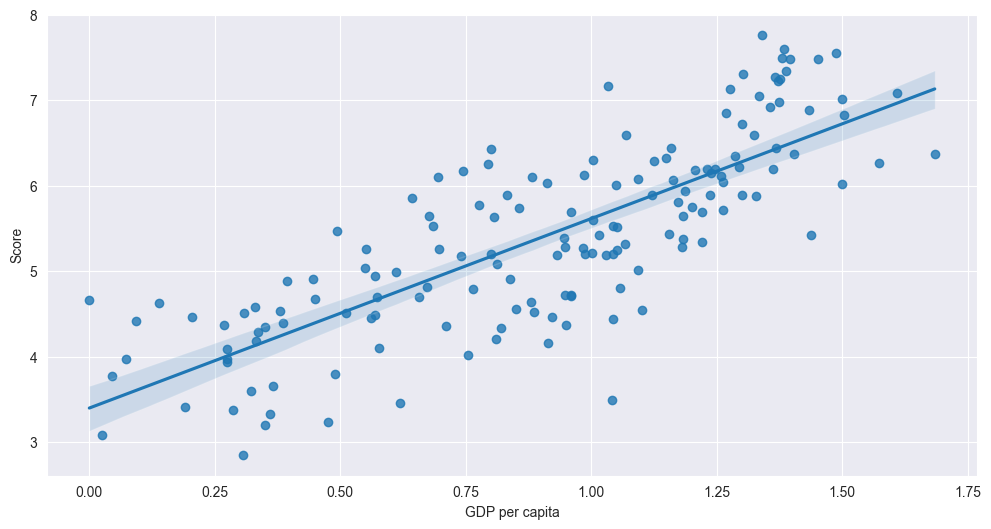

In [60]:
# x='GDP per Capita', y='Score'
sns.regplot(x='GDP per capita', y='Score', data=df)
#plt.show()

Ми моделюватимемо цю залежність. Тобто незалежною змінною є `GDP per capita`, залежною `Score`. Судячи з діаграми розсіювання, залежність між цими двома змінними має добре описуватись лінійною моделлю.

## Розв'язання задачі лінійної регресії методом градієнтного спуску

Позначення:
- `X` - матриця ознак
- `y` - цільова змінна
- `theta` - вектор параметрів
- `alpha` - темп навчання (learning rate)

<font color='blue'>**[Optional]**</font> 3. Реалізуйте формулу передбачення лінійної регресії у методі `predict`. Метод повертає передбачення. Нагадаю, що для кожного спостереження з матриці ознак передбачення знаходимо за допомогою наступної формули:
$$x \in X, i \in [1,m], j : \\ \hat{y}_i = \theta_0 + \theta_1 x_1 + ... + \theta_n x_n = \theta^T x ,\\
\text{де m - кількість спостережень, } \\
\text{n - кількість ознак, } \\
x_0 = 1 \ \text{для всіх спостережень}.
$$

Передбачення всіх спостережень у матриці Х можемо знайти як множення матриці ознак на ваги.

In [61]:
def predict_my(x, theta):
    #theta_0 = 1.8115 #theta 0
    prediction = x.dot(theta) #+ theta_0
    return  prediction


<font color='blue'>**[Optional]**</font> 4. Доповніть обчислення значення функції витрат, формула якої наведена в слайдах лекції про лінійну регресію (підказка - формула така сама, якби ми рахували середньоквадратичну помилку).  
Метод `cost()` приймає вектор параметрів `theta`, матрицю наших ознак `X` та реальні значення цільової змінної `y`.


In [62]:
def cost(theta, x, y_true):
    y_estimate = predict_my(x, theta)
    m = len(y_true)
    cost_value = (1 / (2 * m)) * sum((y_estimate[i] - y_true[i]) ** 2 for i in range(m))
    return cost_value


<font color='blue'>**[Optional]**</font> 5. Ознайомтеся з реалізацією методу `get_gradient()`, який повертає вектор часткових похідних функції витрат за кожним із параметрів лінійної регресії.
Доповніть метод `gradient_descent()`, який дозволить реалізувати алгоритм градієтного спуску. Під час градієнтного спуку ми оновлюємо параметри згідно з формулою:
$$
\text{для кожного} \ j \in [0, n]: \quad \theta_j := \theta_j - \alpha \frac{\partial}{\partial \theta_j}J(\theta), \\
\text{де n - кількість ознак}
$$
  Метод градієнтного спуску оновлює ваги (модель навчається) поки вони не перестануть змінюватися від ітерації до ітерації, тобто поки Евклідова відстань (звичайна відстань між веткорами, як у шкільній геометрії) між векторами ваг за останні дві ітерації не буде меншою за невелику константу (зазвичай позначається як $\epsilon$ (епсілон), ми встановимо $\epsilon=10^{-6}$).

В `gradient_descent()` заповніть всі місця, де стоять три крапки. Використовуйте реалізовані у попередніх завданнях методи `cost()` та `predict()`, і звичайно ж Вам знадобиться метод `get_gradient()`.

In [63]:
def get_gradient(x, y, theta):
    m = len(y)
    predictions = x.dot(theta)
    errors = predictions - y
    gradient = (1/m) * x.T.dot(errors)
    return gradient


In [64]:
def gradient_descent(X, y, theta, learning_rate, eps, max_iterations):
    cost_history = []
    theta_history = []
    iterations = 1

    while True:
        # Передбачення з поточними значеннями вагів
        y_estimate = predict_my(X, theta)

        # Значення часткових похідних функції витрат з поточними значеннями ваг
        gradient = get_gradient(X, y, theta)

        # Значення функції витрат при поточних вагах  Verbesserung des Fehlers або "покращення помилки"
        cost_value = cost(theta, X, y)
        cost_history.append(cost_value)

        # Оновлення ваг
        new_theta = theta - learning_rate * gradient
        theta_history.append(new_theta)

        # Умова зупинки (конвергенція)
        if np.linalg.norm(new_theta - theta) < eps:
            print("Алгоритм зійшовся.")
            break

        # Друга умова зупинки (максимальна кількість ітерацій)
        if iterations >= max_iterations:
            print("Досягнуто максимальної кількості ітерацій")
            break

        # Виводимо інформацію кожні 100 ітерацій
        if iterations % 100 == 0:
           # print("Ітерація: %d - Помилка на трейн даних: %.4f" % (iterations, cost_value))
            print("Ітерація: %d - Помилка на трейн даних: %.4f" % (iterations, cost_value[0]))


        iterations += 1
        theta = new_theta

    return theta, cost_history, theta_history, iterations


Підготуємо дані.

In [65]:
x = df['GDP per capita']
x

0      1.340
1      1.383
2      1.488
3      1.380
4      1.396
       ...  
151    0.359
152    0.476
153    0.350
154    0.026
155    0.306
Name: GDP per capita, Length: 156, dtype: float64

In [66]:
#DataFrame df in ein zweidimensionales NumPy-Array umgewandelt, das nur eine Spalte hat. Diese Operation ist nützlich, wenn man mit Scikit-Learn oder anderen Bibliotheken arbeitet, die als Eingabe ein 2D-Array erwarten, auch wenn man nur mit einer einzelnen Feature-Spalte arbeitet.

x = df['GDP per capita'].values.reshape(-1,1)
y = df['Score'] .values.reshape(-1,1)
#x

6. Розділіть `X` та `y` на `train` і `test` підвиборки у співвідношенні 80/20. Оскільки у нас мало даних, валідаційну вибірку не виділятимемо. Запишіть результати у `X_train`, `y_train`, `X_test`, `y_test`.

In [67]:
# Розділення даних на навчальні та тестові
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.20, random_state=42)


7.Реалізуйте масштабування ознак із використанням `MinMaxScaler`. Пам'ятайте про те, як ми застосовуємо масштабування ознак на`train` та `test` вибірках.

In [68]:
# Створення об'єкту MinMaxScaler
scaler = MinMaxScaler()

# Масштабування навчальної вибірки
x_train_scaled = scaler.fit_transform(x_train)

# Масштабування тестової вибірки
# ВАЖЛИВО: використовувати ті ж параметри масштабування, що й для навчальної вибірки
x_test_scaled = scaler.transform(x_test)

# Тепер x_train_scaled та x_test_scaled містять масштабовані ознаки

x_train_scaled


array([[0.66508314],
       [0.16330166],
       [0.54691211],
       [0.15914489],
       [0.22862233],
       [0.402019  ],
       [0.58491686],
       [0.47505938],
       [0.48159145],
       [0.72505938],
       [0.20783848],
       [0.8087886 ],
       [0.85391924],
       [0.63539192],
       [0.19714964],
       [0.62470309],
       [0.61401425],
       [0.4608076 ],
       [0.70249406],
       [0.33372922],
       [0.83313539],
       [0.52612827],
       [0.22565321],
       [0.73515439],
       [0.82897862],
       [0.66745843],
       [0.32719715],
       [0.12114014],
       [0.72505938],
       [0.81532067],
       [0.3675772 ],
       [0.81472684],
       [0.2672209 ],
       [0.11342043],
       [0.79572447],
       [0.        ],
       [0.57007126],
       [0.41211401],
       [0.70130641],
       [1.        ],
       [0.44239905],
       [0.57007126],
       [0.68824228],
       [0.78622328],
       [0.39014252],
       [0.71615202],
       [0.41330166],
       [0.027

<font color='blue'>**[Optional]**</font> 8. Додайте колонку з одиниць до масивів `X_train`, `X_test`.

In [69]:
# Додавання колонки з одиницями до X_train
ones_train = np.ones((x_train.shape[0], 1)) # Створення колонки одиниць для кожного рядка в X_train
x_train_1 = np.hstack((ones_train, x_train)) # Горизонтальне з'єднання колонки з X_train
x_train_scaled_1 = np.hstack((ones_train, x_train_scaled)) # Горизонтальне з'єднання колонки з X_train


# Додавання колонки з одиницями до X_test
ones_test = np.ones((x_test.shape[0], 1)) # Створення колонки одиниць для кожного рядка в X_test
x_test_1  = np.hstack((ones_test, x_test)) # Горизонтальне з'єднання колонки з X_test
x_test_scaled_1  = np.hstack((ones_test, x_test_scaled)) # Горизонтальне з'єднання колонки з X_test

x_train_scaled_1


array([[1.        , 0.66508314],
       [1.        , 0.16330166],
       [1.        , 0.54691211],
       [1.        , 0.15914489],
       [1.        , 0.22862233],
       [1.        , 0.402019  ],
       [1.        , 0.58491686],
       [1.        , 0.47505938],
       [1.        , 0.48159145],
       [1.        , 0.72505938],
       [1.        , 0.20783848],
       [1.        , 0.8087886 ],
       [1.        , 0.85391924],
       [1.        , 0.63539192],
       [1.        , 0.19714964],
       [1.        , 0.62470309],
       [1.        , 0.61401425],
       [1.        , 0.4608076 ],
       [1.        , 0.70249406],
       [1.        , 0.33372922],
       [1.        , 0.83313539],
       [1.        , 0.52612827],
       [1.        , 0.22565321],
       [1.        , 0.73515439],
       [1.        , 0.82897862],
       [1.        , 0.66745843],
       [1.        , 0.32719715],
       [1.        , 0.12114014],
       [1.        , 0.72505938],
       [1.        , 0.81532067],
       [1.

<font color='blue'>**[Optional]**</font> 9. Встановіть темп навчання рівний 0.01, точність епсілон рівний $10^{-6}$, кількість ітерацій дорівнює 20000 і запустіть градієнтний спуск на тренувальні дані, передавши всі необхідні параметри.

In [70]:
learning_rate = 0.01
max_iterations = 20000
epsilon = 1e-6

theta = np.random.randn(2,1)
#theta

## порахуємо theta0 та theta 1 методом градіентного спуску

In [71]:
#для порівняння проженемо алгоритм на не ітерованих даних
#theta, cost_history, theta_history, iterations = gradient_descent(x_train_1, y_train, theta, learning_rate, epsilon, max_iterations) 
#theta

## а тепер те проженемо алгоритм градіент спуску для скальованих даних. Наші дані в змінній x_train_scaled_1 

In [72]:
theta, cost_history, theta_history, iterations = gradient_descent(x_train_scaled_1, y_train, theta, learning_rate, epsilon, max_iterations)

Ітерація: 100 - Помилка на трейн даних: 1.0605
Ітерація: 200 - Помилка на трейн даних: 0.3435
Ітерація: 300 - Помилка на трейн даних: 0.2853
Ітерація: 400 - Помилка на трейн даних: 0.2761
Ітерація: 500 - Помилка на трейн даних: 0.2709
Ітерація: 600 - Помилка на трейн даних: 0.2664
Ітерація: 700 - Помилка на трейн даних: 0.2623
Ітерація: 800 - Помилка на трейн даних: 0.2586
Ітерація: 900 - Помилка на трейн даних: 0.2552
Ітерація: 1000 - Помилка на трейн даних: 0.2521
Ітерація: 1100 - Помилка на трейн даних: 0.2493
Ітерація: 1200 - Помилка на трейн даних: 0.2468
Ітерація: 1300 - Помилка на трейн даних: 0.2445
Ітерація: 1400 - Помилка на трейн даних: 0.2423
Ітерація: 1500 - Помилка на трейн даних: 0.2404
Ітерація: 1600 - Помилка на трейн даних: 0.2387
Ітерація: 1700 - Помилка на трейн даних: 0.2371
Ітерація: 1800 - Помилка на трейн даних: 0.2356
Ітерація: 1900 - Помилка на трейн даних: 0.2343
Ітерація: 2000 - Помилка на трейн даних: 0.2331
Ітерація: 2100 - Помилка на трейн даних: 0.2320
І

In [73]:
theta

array([[3.42220589],
       [3.70797933]])

## помітили що тета 0 така сама а тета 0 змінилась

<font color='blue'>**[Optional]**</font> 10. Відобразіть на лінійному графіку значення змінної `cost_history`. Використовуйте будь-яку бібліотеку для візуалізації на вибір.

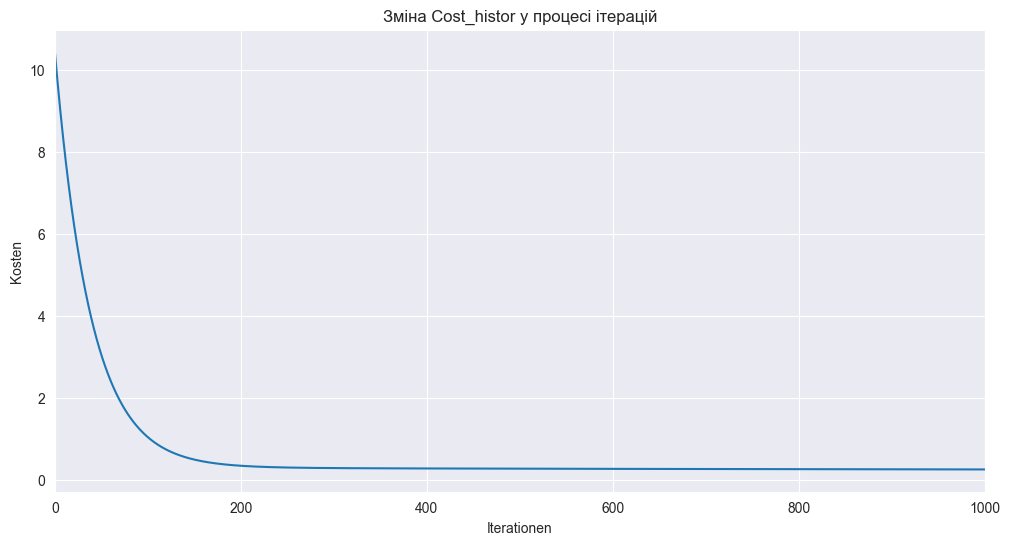

In [74]:
# Erstellen des Plots
#plt.figure(figsize=(10, 6))
plt.plot(cost_history)
plt.title('Зміна Cost_histor у процесі ітерацій')
plt.xlim(0, 1000)
plt.xlabel('Iterationen')
plt.ylabel('Kosten')
plt.grid(True)
#plt.show()

Відобразіть лише перші 200 ітерацій. Схоже, що після них модель мало навчається. Ми могли б застосувати техніку early stopping у даному випадку та зупинитися на деякій невеликій кількості ітерацій. Зазвичай ця техніка застосовується, щоб уникнути перенавчання. При цьому втрачається трохи точності на train set.

Виведемо отримані параметри та останнє значення функції витрат.

In [75]:
print('Theta_0:          {:0.3f},\nTheta_1:          {:0.3f}'.format(theta[0][-1], theta[1][-1]))
print('Final cost/MSE:  {:0.3f}'.format(cost_history[-1].item()))
#print('Number of iterations: {:d}'.format(iterations))


Theta_0:          3.422,
Theta_1:          3.708
Final cost/MSE:  0.221


<font color='blue'>**[Optional]**</font> 11. Знайдіть прогнози на `X_train`, `X_test` та порахуйте `mean_squared_error` помилку прогнозів обох підвибірках.

In [76]:


# Розрахунок прогнозів для тренувальних і тестових даних
y_train_pred_my = predict_my(x_train_scaled_1, theta)
y_test_pred_my = predict_my(x_test_scaled_1, theta)

#print("прогнозів для тренувальних даних:", y_train_pred)
#print("прогнозів для тest даних:", y_test_pred)


# Розрахунок середньоквадратичної помилки
mse_train_my = mean_squared_error(y_train, y_train_pred_my)
mse_test_my = mean_squared_error(y_test, y_test_pred_my)

print("Середньоквадратична помилка на тренувальних даних:", mse_train_my)
print("Середньоквадратична помилка на тестових даних:", mse_test_my)

df_MSE_train.loc["my_Model", "MSE"] = mse_train_my
df_MSE_test.loc["my_Model", "MSE"] = mse_test_my
df_MSE_train



Середньоквадратична помилка на тренувальних даних: 0.44172140535304444
Середньоквадратична помилка на тестових даних: 0.5079401669717492


,MSE,RMSE
my_Model,0.441721,None
model_2_dim1(lr_1_dim ),None,None
lr.predict (lr dim 7),None,None
Poly_Regression,None,None
ElasticNet,None,None


In [77]:
df_MSE_test

,MSE,RMSE
my_Model,0.50794,None
model_2_dim1(lr_1_dim ),None,None
lr.predict (lr dim 7),None,None
Poly_Regression,None,None
ElasticNet,None,None


<font color='blue'>**[Optional]**</font> 12. Виведіть діаграму розсіювання ознак `Score` та `GDP per capita` та додайте лінію прогнозу моделі.

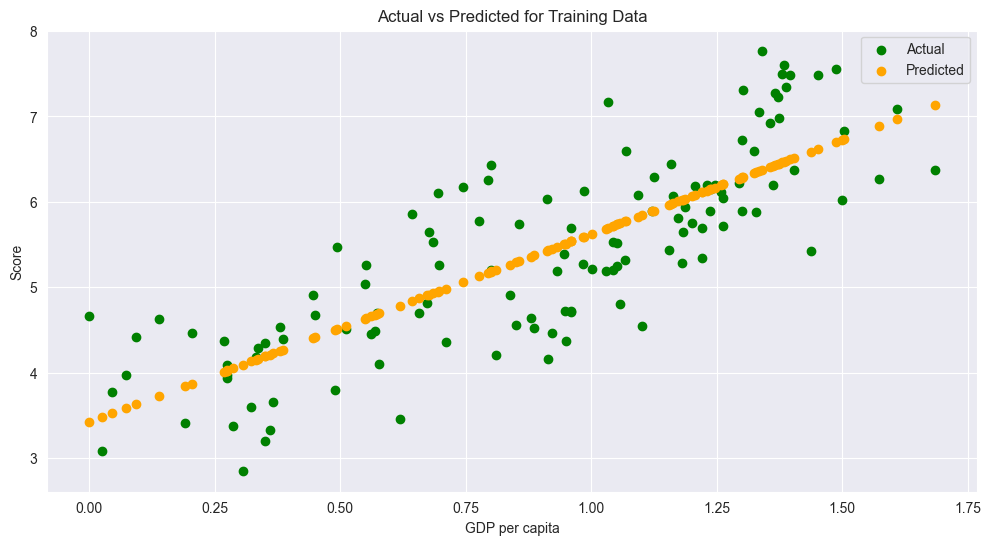

In [78]:
# Діаграма розсіювання для training даних
plt.scatter(x_train, y_train, color='green', label='Actual')
plt.scatter(x_train, y_train_pred_my, color='orange', label='Predicted')
plt.title('Actual vs Predicted for Training Data')
plt.xlabel('GDP per capita')
plt.ylabel('Score')
plt.legend()

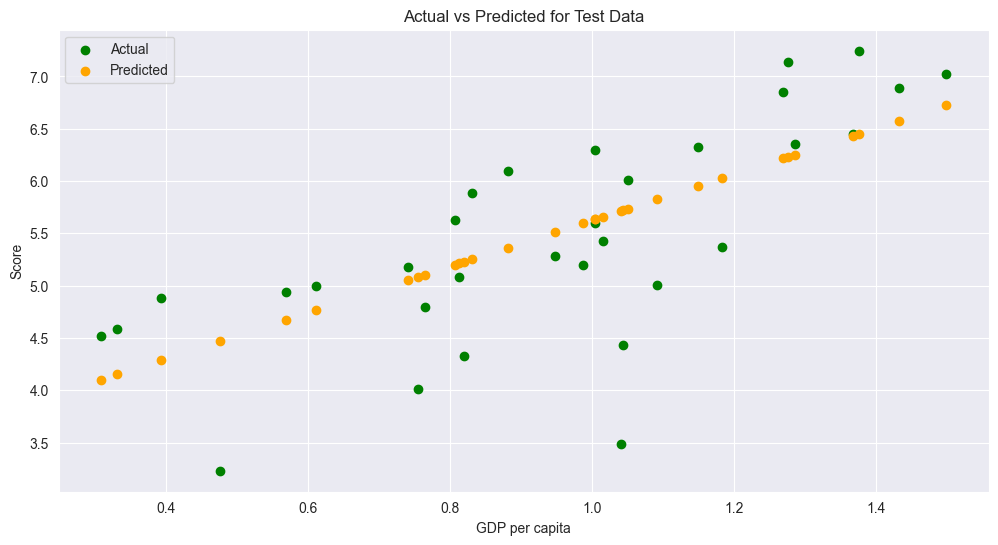

In [79]:



# Діаграма розсіювання для тестових даних
plt.scatter(x_test, y_test, color='green', label='Actual')
plt.scatter(x_test, y_test_pred_my, color='orange', label='Predicted')
plt.title('Actual vs Predicted for Test Data')
plt.xlabel('GDP per capita')
plt.ylabel('Score')
plt.legend()
#plt.show()


13. Навчіть лінійну регресію на наборі даних, що складається тільки з ознаки `GDP per capita`, але тепер використовуючи LinearRegression з sklearn.   
Подумайте, чи треба в sklearn модель подавати стовпчик з одиниць, яку ми подавали в самописну модель.

## ні, стовбчика з одиниць для реалізованої моделі склерн не потрібно.

In [80]:
#für X_train_scaled
# Створення екземпляра LinearRegression
model_2_dim1 = LinearRegression()

# Навчання моделі
model_2_dim1.fit(x_train_scaled, y_train)

# Оцінювання моделі (опціонально)
model_2_dim1.score(x_test_scaled, y_test)

0.5119632343226919

## чомусь нема різниці між X_train та X_train_scaled. Дивно ?  Стовбчик одиниць додавати не треба

Порівняйте помилку на тестовій вибірці лінійної регресії, написаної вами, та зі sklearn. Чи є різниця у значеннях?

In [81]:
# Отримання прогнозів на тестових даних
y_train_pred_lr_1dim = model_2_dim1.predict(x_train_scaled)
y_test_pred_lr_1dim = model_2_dim1.predict(x_test_scaled)

# Розрахунок MSE
mse_train_lr_dim1 = mean_squared_error(y_train, y_train_pred_lr_1dim)
mse_test_lr_dim1 = mean_squared_error(y_test, y_test_pred_lr_1dim)
#mse_test_my_model = mean_squared_error(y_test,  y_test_pred_my)

print("MSE на тестових даних для my моєї предікт :", mse_test_my)
print("MSE на тестових даних для предікт від  lr sklearn:", mse_test_lr_dim1)

df_MSE_train.loc["model_2_dim1(lr_1_dim )", "MSE"] = mse_train_lr_dim1
df_MSE_test.loc["model_2_dim1(lr_1_dim )", "MSE"] = mse_test_lr_dim1
df_MSE_train




MSE на тестових даних для my моєї предікт : 0.5079401669717492
MSE на тестових даних для предікт від  lr sklearn: 0.5079112698997723


,MSE,RMSE
my_Model,0.441721,None
model_2_dim1(lr_1_dim ),0.441721,None
lr.predict (lr dim 7),None,None
Poly_Regression,None,None
ElasticNet,None,None


In [82]:
df_MSE_test

,MSE,RMSE
my_Model,0.50794,None
model_2_dim1(lr_1_dim ),0.507911,None
lr.predict (lr dim 7),None,None
Poly_Regression,None,None
ElasticNet,None,None


## різниця лише у 5му знаку після коми.

14. Навчимо лінійну регресію на більшій кількості ознак і подивимося, чи вдасться покращити модель.

14.1 Навчіть лінійну регресію з sklearn використовуючи як набор ознак наступний: `GDP per capita`, `Social support`, `Healthy life expectancy`, `Freedom to make life choices`, `Generosity`, `Perceptions of corruption`

Не забудьте:  
1. Розділити `train` та `test`.
2. Нормувати кожну колонку даних.

## Взагалі то треба було б розділити індекси. Але вже так. Наступного разу зроблю поділ по індексам.

In [83]:
X = df.drop(['Score'],axis=1)
X = X.drop(['Country or region'], axis=1)
y = df['Score']

#aufteilen von Daten
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

# Створення об'єкту MinMaxScaler
scaler = MinMaxScaler()

# Масштабування навчальної вибірки
X_train_scaled = scaler.fit_transform(X_train)

# Масштабування тестової вибірки
# ВАЖЛИВО: використовувати ті ж параметри масштабування, що й для навчальної вибірки
X_test_scaled = scaler.transform(X_test)

# Тепер X_train_scaled та X_test_scaled містять масштабовані ознаки

X_train_scaled
#X_train_scaled

array([[0.36129032, 0.66508314, 0.86330049, 0.6993865 , 0.78922345,
        0.37985866, 0.13245033],
       [0.89032258, 0.16330166, 0.35221675, 0.35933392, 0.46434231,
        0.31272085, 0.18763797],
       [0.79354839, 0.54691211, 0.61576355, 0.71428571, 0.26465927,
        0.10424028, 0.1214128 ],
       [0.82580645, 0.15914489, 0.51785714, 0.21209465, 0.48969889,
        0.44522968, 0.09933775],
       [0.81935484, 0.22862233, 0.68041872, 0.26993865, 0.51822504,
        0.27031802, 0.11479029],
       [0.42580645, 0.402019  , 0.5455665 , 0.46888694, 0.49603803,
        0.38869258, 0.21633554],
       [0.27096774, 0.58491686, 0.8682266 , 0.73707274, 0.74484945,
        0.17491166, 0.07505519],
       [0.16774194, 0.47505938, 0.78140394, 0.65381245, 0.84786054,
        0.30918728, 0.17218543],
       [0.86451613, 0.48159145, 0.70751232, 0.        , 0.49603803,
        0.13074205, 0.29801325],
       [0.50967742, 0.72505938, 0.72105911, 0.72567923, 0.80507132,
        0.45936396, 0.0

14.2 Виведіть помилку прогнозу на `train` та `test` вибірках. Порівняйте з результатом, отриманим під час навчання однією ознакою. Чи змінилися метрики?

In [84]:
lr = LinearRegression() #model 7features

lr.fit(X_train_scaled,y_train)

lr.score(X_test_scaled, y_test) # score дає квадрати 

0.9770579560089099

In [85]:
y_train_pred_lr_7 = lr.predict(X_train_scaled)
y_test_pred_lr_7 = lr.predict(X_test_scaled)

mse_train_X_lr_7 = mean_squared_error(y_train, y_train_pred_lr_7)
mse_test_X_lr_7 = mean_squared_error(y_test, y_test_pred_lr_7)

df_MSE_train.loc["lr.predict (lr dim 7)", "MSE"] =mse_train_X_lr_7
df_MSE_test.loc["lr.predict (lr dim 7)", "MSE"] =mse_test_X_lr_7

df_MSE_train
df_MSE_test



,MSE,RMSE
my_Model,0.50794,None
model_2_dim1(lr_1_dim ),0.507911,None
lr.predict (lr dim 7),0.023876,None
Poly_Regression,None,None
ElasticNet,None,None


In [86]:
## як бачимо стало краще.  Середнтоквадратична помилка зменшилась більш ніж вдвічі

14.3 Виведіть коефіцієнти моделі і визначте, які ознаки мають найбільші коефіцієнти по модулю, що стоять перед ними (достатньо вивести назви ознак і коефіцієнти в одному датафреймі).

In [87]:
abs_coef = abs(lr.coef_) # 
coeff_df = pd.DataFrame({'Feature': X_train.columns, 'Coefficient |theta|': abs_coef})
coeff_df

,Feature,Coefficient |theta|
0,Overall rank,3.506525
1,GDP per capita,0.054281
2,Social support,0.438554
3,Healthy life expectancy,0.029401
4,Freedom to make life choices,0.114464
5,Generosity,0.084918
6,Perceptions of corruption,0.224217


Feature: Overall rank, Score: -3.507
Feature: GDP per capita, Score: -0.054
Feature: Social support, Score: 0.439
Feature: Healthy life expectancy, Score: -0.029
Feature: Freedom to make life choices, Score: 0.114
Feature: Generosity, Score: 0.085
Feature: Perceptions of corruption, Score: 0.224


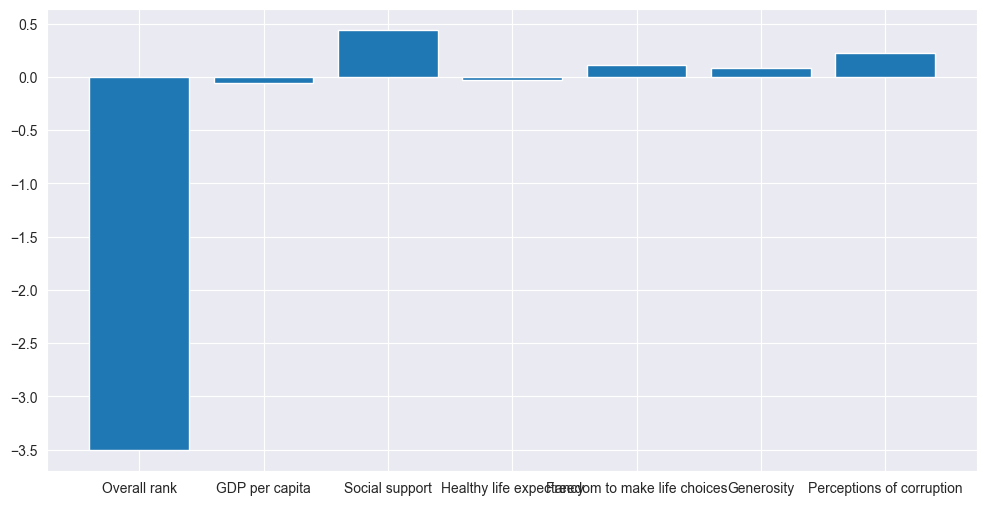

In [88]:
importance = lr.coef_
for feature_name, value in zip(X.columns, importance):
    print(f'Feature: {feature_name}, Score: {value:.3f}')

# побудуємо графік
xticks = range(len(importance))
plt.bar(xticks, importance)
plt.xticks()
plt.xticks(xticks, X.columns)
plt.show()

15. Навчіть модель поліноміальної регресії зі ступенем 2 на тих самих даних, що й у попередньому пункті. Використовуйте у процесі навчання `PolynomialFeatures`. Дослідіть метрики якості на трейні та тест датасетах. Чи є перенавчання (overfit)?

In [89]:
poly = PolynomialFeatures(2)
X_train_poly = poly.fit_transform(X_train_scaled)
X_test_poly = poly.transform(X_test_scaled)
X_train_poly

array([[1.        , 0.36129032, 0.66508314, ..., 0.1442926 , 0.0503124 ,
        0.01754309],
       [1.        , 0.89032258, 0.16330166, ..., 0.09779433, 0.0586783 ,
        0.03520801],
       [1.        , 0.79354839, 0.54691211, ..., 0.01086604, 0.0126561 ,
        0.01474107],
       ...,
       [1.        , 0.09032258, 0.7915677 , ..., 0.37802944, 0.37731964,
        0.37661116],
       [1.        , 0.59354839, 0.61104513, ..., 0.01050082, 0.02262108,
        0.04873081],
       [1.        , 0.65806452, 0.39964371, ..., 0.03441484, 0.03808532,
        0.04214727]])

In [94]:

new_model = LinearRegression()
# Erstellen der Pipeline
#model = make_pipeline(poly, LinearRegression())

# Trainieren des Modells
new_model.fit(X_train_poly, y_train)

# Vorhersagen und Bewertung des Modells
y_train_pred_poly = new_model.predict(X_train_poly)
y_test_pred_poly = new_model.predict(X_test_poly)

mse_train_poly= mean_squared_error(y_train, y_train_pred_poly)
mse_test_poly= mean_squared_error(y_test, y_test_pred_poly)

#df_MSE_train.loc["Poly_Regression", "MSE"] = mse_train_poly

train_rmse_poly = root_mean_squared_error(y_train, y_train_pred_poly)
test_rmse_poly = root_mean_squared_error(y_test, y_test_pred_poly)
train_r2_poly = r2_score(y_train, y_train_pred_poly)
test_r2_poly = r2_score(y_test, y_test_pred_poly)

# Ausgabe der Metriken
print(" Poly_Regression Trainingsdaten: RMSE =", train_rmse_poly, ", R2 =", train_r2_poly)
print(" Poly_Regression Testdaten: RMSE =", test_rmse_poly, ", R2 =", test_r2_poly)

# Überprüfung auf Overfitting
if train_rmse_poly+0.1 < test_rmse_poly or train_r2_poly > test_r2_poly+ 0.1 :
    print("Можливо наявний оверфітінг.")
else:
    print("Явного оверфітінгу немає. )")


 Poly_Regression Trainingsdaten: RMSE = 0.11400127165365226 , R2 = 0.9898423661542971
 Poly_Regression Testdaten: RMSE = 0.14527940775457535 , R2 = 0.9797197729727939
Явного оверфітінгу немає. )


In [95]:
df_MSE_train.loc["Poly_Regression", "MSE"] =mse_train_poly
df_MSE_test.loc["Poly_Regression", "MSE"] = mse_test_poly

df_MSE_train


,MSE,RMSE
my_Model,0.441721,None
model_2_dim1(lr_1_dim ),0.441721,None
lr.predict (lr dim 7),0.02242,None
Poly_Regression,0.012996,None
ElasticNet,None,None


In [96]:
df_MSE_test

,MSE,RMSE
my_Model,0.50794,None
model_2_dim1(lr_1_dim ),0.507911,None
lr.predict (lr dim 7),0.023876,None
Poly_Regression,0.021106,None
ElasticNet,None,None


16. Зробіть пайплайн із кроками `MinMaxScaler`, `PolynomialFeatures` та `ElasticNet`.



In [97]:
from sklearn.pipeline import Pipeline
from sklearn.linear_model import ElasticNet

pipeline = Pipeline([
    ('scaler', MinMaxScaler()),
    ('poly_features', PolynomialFeatures(degree=2)),
    ('elastic_net', ElasticNet())
])

# Trainieren der Pipeline mit Ihren Daten
# Angenommen, X_train und y_train sind Ihre Trainingsdaten
pipeline.fit(X_train, y_train)

# Vorhersagen oder Evaluierung der Pipeline
# Zum Beispiel: Vorhersagen auf Testdaten X_test
y_train_pipeline_pred = pipeline.predict(X_train)
y_test_pipeline_pred = pipeline.predict(X_test)


mse_train_ElasticNet =mean_squared_error(y_train, y_train_pipeline_pred)
mse_test_ElasticNet =mean_squared_error(y_test, y_test_pipeline_pred)

df_MSE_train.loc["ElasticNet","MSE"]= mse_train_ElasticNet
df_MSE_test.loc["ElasticNet","MSE"]= mse_test_ElasticNet

train_rmse = root_mean_squared_error(y_train, y_train_pipeline_pred)
test_rmse = root_mean_squared_error(y_test, y_test_pipeline_pred)
train_r2 = r2_score(y_train, y_train_pipeline_pred)
test_r2 = r2_score(y_test, y_test_pipeline_pred)

# Ausgabe der Metriken
print("ElasticNet Trainingsdaten: RMSE =", train_rmse, ", R2 =", train_r2)
print("ElasticNet Testdaten: RMSE =", test_rmse, ", R2 =", test_r2)

df_MSE_test

# Hier können Sie weitere Schritte zur Bewertung oder Verwendung der Vorhersagen durchführen


ElasticNet Trainingsdaten: RMSE = 1.1311323388715853 , R2 = 0.0
ElasticNet Testdaten: RMSE = 1.0219743615514894 , R2 = -0.0035631184593831744


,MSE,RMSE
my_Model,0.50794,None
model_2_dim1(lr_1_dim ),0.507911,None
lr.predict (lr dim 7),0.023876,None
Poly_Regression,0.021106,None
ElasticNet,1.044432,None


Яка модель у домашньому завданні дала найкращі значення середньоквадратичної помилки на тестових даних, лін. регресія написана самостійно, лін. регресія зі sklearn, поліноміальна регресія?

In [293]:

print("Середньоквадратична помилка (MSE) на тренувальних даних для lr.predict від sklearn:", train_mse)
print("Середньоквадратична помилка (MSE) на тестових даних для lr.predict від sklearn:", test_mse)

#ще раз для однієї змінної

print("Середньоквадратична помилка (MSE) на тестових даних для предікт від sklearn 1 змінна:",sklearn_mse)
print("Середньоквадратична помилка (MSE) на тестових даних для моєї предікт 1 змінна:",my_model_mse)


print("Середньоквадратична помилка (MSE) на тестових даних для предікт від sklearn:",sklearn_mse)
print("Середньоквадратична помилка (MSE) на тестових даних для моєї предікт :",my_model_mse)

print(" Poly_Regression Trainingsdaten: RMSE =", train_rmse, ", R2 =", train_r2)
print(" Poly_Regression Testdaten: RMSE =", test_rmse, ", R2 =", test_r2)
print("ElasticNet Trainingsdaten: RMSE =", train_rmse, ", R2 =", train_r2)
print("ElasticNet Testdaten: RMSE =", test_rmse, ", R2 =", test_r2)

Середньоквадратична помилка (MSE) на тренувальних даних для lr.predict від sklearn: 0.02242029538225759
Середньоквадратична помилка (MSE) на тестових даних для lr.predict від sklearn: 0.02387632145180575
Середньоквадратична помилка (MSE) на тестових даних для предікт від sklearn 1 змінна: 0.5079112698997723
Середньоквадратична помилка (MSE) на тестових даних для моєї предікт 1 змінна: 0.5079401606839119
Середньоквадратична помилка (MSE) на тестових даних для предікт від sklearn: 0.5079112698997723
Середньоквадратична помилка (MSE) на тестових даних для моєї предікт : 0.5079401606839119
 Poly_Regression Trainingsdaten: RMSE = 0.11400127165365226 , R2 = 0.9898423661542971
 Poly_Regression Testdaten: RMSE = 0.14527940775457535 , R2 = 0.9797197729727939
ElasticNet Trainingsdaten: RMSE = 0.11400127165365226 , R2 = 0.9898423661542971
ElasticNet Testdaten: RMSE = 0.14527940775457535 , R2 = 0.9797197729727939


In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import ElasticNet
from sklearn.model_selection import GridSearchCV

# Erstellen der Pipeline

pipeline = Pipeline([
    ('scaler', MinMaxScaler()),
    ('poly_features', PolynomialFeatures(degree=2)),
    ('elastic_net', ElasticNet())
])


# Festlegen des Parametergitters
param_grid = {
    'poly__degree': [1, 2, 3],  # Verschiedene Grade für PolynomialFeatures
    'elasticnet__alpha': [0.1, 1, 10],  # Verschiedene Alpha-Werte für ElasticNet
    'elasticnet__l1_ratio': [0.1, 0.5, 0.9]  # Verschiedene l1_ratio-Werte für ElasticNet
}

# Erstellen von GridSearchCV
grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring='neg_mean_squared_error')

# Trainieren von GridSearchCV mit Ihren Daten
# Angenommen, X_train und y_train sind Ihre Trainingsdaten
grid_search.fit(X_train, y_train)

# Bestes Modell
best_model = grid_search.best_estimator_

# Sie können dann das beste Modell verwenden, um Vorhersagen zu machen oder weiter zu analysieren
